# Introduction and Processing of the Data

> **TODO:** several paragraphs indicating:
> - What is the work about?
> - Why is it interesting?
> - Business volume of the domain
> - Local/national importance and relevance in the current context 
>
> It's important to provide a solid justification for the interest in the domain and link to relevant sites as well as references.



### Dataset Description

> **TODO:** dataset description indicating:
> - Size in KB/MB/GB
> - Number of rows and columns
> - Where the dataset was sourced from
> - Types of data and specific meanings of the really important columns.

### Data Processing

> **TODO:** describe the details, problems, and transformations applied when importing and cleaning the dataset.

First, we will import the necessary libraries.

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from PyPDF2 import PdfReader

Now, we will load the dataset, fix some column names and display the first few rows and its types to understand the structure of the data.

In [3]:
raw_df: pl.DataFrame = pl.read_csv(
    "../data/raw/world-data-2023.csv", ignore_errors=True
)

# Fix some column names
raw_df = raw_df.rename({"Density\r\n(P/Km2)": "Density(P/Km2)"})
raw_df = raw_df.rename({"Agricultural Land( %)": "Agricultural Land(%)"})
raw_df = raw_df.rename({"Urban_population": "Urban population"})

# Display first 5 rows and column types
raw_df.head(5)

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,str,str,str,str,str,f64,i64,str,str,f64,str,str,f64,str,str,str,str,str,f64,str,f64,i64,str,str,str,f64,str,str,str,str,str,str,f64,f64
"""Afghanistan""","""60""","""AF""","""58.10%""","""652,230""","""323,000""",32.49,93,"""Kabul""","""8,672""",149.9,"""2.30%""","""AFN""",4.47,"""2.10%""","""$0.70 ""","""$19,101,353,833 ""","""104.00%""","""9.70%""",47.9,"""Kabul""",64.5,638,"""$0.43 ""","""Pashto""","""78.40%""",0.28,"""38,041,754""","""48.90%""","""9.30%""","""71.40%""","""11.12%""","""9,797,273""",33.93911,67.709953
"""Albania""","""105""","""AL""","""43.10%""","""28,748""","""9,000""",11.78,355,"""Tirana""","""4,536""",119.05,"""1.40%""","""ALL""",1.62,"""28.10%""","""$1.36 ""","""$15,278,077,447 ""","""107.00%""","""55.00%""",7.8,"""Tirana""",78.5,15,"""$1.12 ""","""Albanian""","""56.90%""",1.2,"""2,854,191""","""55.70%""","""18.60%""","""36.60%""","""12.33%""","""1,747,593""",41.153332,20.168331
"""Algeria""","""18""","""DZ""","""17.40%""","""2,381,741""","""317,000""",24.28,213,"""Algiers""","""150,006""",151.36,"""2.00%""","""DZD""",3.02,"""0.80%""","""$0.28 ""","""$169,988,236,398 ""","""109.90%""","""51.40%""",20.1,"""Algiers""",76.7,112,"""$0.95 ""","""Arabic""","""28.10%""",1.72,"""43,053,054""","""41.20%""","""37.20%""","""66.10%""","""11.70%""","""31,510,100""",28.033886,1.659626
"""Andorra""","""164""","""AD""","""40.00%""","""468""",null,7.2,376,"""Andorra la Vella""","""469""",null,null,"""EUR""",1.27,"""34.00%""","""$1.51 ""","""$3,154,057,987 ""","""106.40%""",null,2.7,"""Andorra la Vella""",null,null,"""$6.63 ""","""Catalan""","""36.40%""",3.33,"""77,142""",null,null,null,null,"""67,873""",42.506285,1.521801
"""Angola""","""26""","""AO""","""47.50%""","""1,246,700""","""117,000""",40.73,244,"""Luanda""","""34,693""",261.73,"""17.10%""","""AOA""",5.52,"""46.30%""","""$0.97 ""","""$94,635,415,870 ""","""113.50%""","""9.30%""",51.6,"""Luanda""",60.8,241,"""$0.71 ""","""Portuguese""","""33.40%""",0.21,"""31,825,295""","""77.50%""","""9.20%""","""49.10%""","""6.89%""","""21,061,025""",-11.202692,17.873887


We observed that some of the columns are not in the correct data type. We will convert them to the correct data type.

Certain columns contain numerical values formatted as strings with commas (`,`) as thousand separators. These need to be cleaned and converted into integers. These columns include:
- `Density(P/Km2)`
- `Land Area(Km2)`
- `Armed Forces size`
- `Co2-Emissions`
- `Population`
- `Urban population`

Some columns contain monetary values formatted as strings with dollar signs (`$`) and commas (`,`) as thousand separators. These need to be cleaned and converted into floats. These columns include:
- `Gasoline Price`
- `GDP`
- `Minimum wage`

Some columns contain percentages formatted as strings with percentage signs (`%`). These need to be cleaned and converted into floats. These columns include:
- `Agricultural Land(%)`
- `CPI Change (%)`
- `Forested Area (%)`
- `Gross primary education enrollment (%)`
- `Gross tertiary education enrollment (%)`
- `Out of pocket health expenditure`
- `Population: Labor force participation (%)`
- `Tax revenue (%)`
- `Total tax rate`
- `Unemployment rate`

In [4]:
data = raw_df.clone()

# Columns that should be integers
int_columns = [
    "Density(P/Km2)",
    "Land Area(Km2)",
    "Armed Forces size",
    "Co2-Emissions",
    "Population",
    "Urban population",
]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all(",", "").cast(pl.Int64)
        for col in int_columns
    ]
)

# Currency columns that should be floats
float_columns_currency = ["Gasoline Price", "GDP", "Minimum wage"]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all(r"[\$,]", "").cast(pl.Float64)
        for col in float_columns_currency
    ]
)

# Percentage columns that should be floats
float_columns_percentage = [
    "Agricultural Land(%)",
    "CPI Change (%)",
    "Forested Area (%)",
    "Gross primary education enrollment (%)",
    "Gross tertiary education enrollment (%)",
    "Out of pocket health expenditure",
    "Population: Labor force participation (%)",
    "Tax revenue (%)",
    "Total tax rate",
    "Unemployment rate",
]
data = data.with_columns(
    [
        pl.col(col).str.strip_chars().str.replace_all("%", "").cast(pl.Float64)
        for col in float_columns_percentage
    ]
)

data.head(5)

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,str,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,str,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""Afghanistan""",60,"""AF""",58.1,652230,323000,32.49,93,"""Kabul""",8672,149.9,2.3,"""AFN""",4.47,2.1,0.7,1.9101e10,104.0,9.7,47.9,"""Kabul""",64.5,638,0.43,"""Pashto""",78.4,0.28,38041754,48.9,9.3,71.4,11.12,9797273,33.93911,67.709953
"""Albania""",105,"""AL""",43.1,28748,9000,11.78,355,"""Tirana""",4536,119.05,1.4,"""ALL""",1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,"""Tirana""",78.5,15,1.12,"""Albanian""",56.9,1.2,2854191,55.7,18.6,36.6,12.33,1747593,41.153332,20.168331
"""Algeria""",18,"""DZ""",17.4,2381741,317000,24.28,213,"""Algiers""",150006,151.36,2.0,"""DZD""",3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,"""Algiers""",76.7,112,0.95,"""Arabic""",28.1,1.72,43053054,41.2,37.2,66.1,11.7,31510100,28.033886,1.659626
"""Andorra""",164,"""AD""",40.0,468,null,7.2,376,"""Andorra la Vella""",469,null,null,"""EUR""",1.27,34.0,1.51,3.1541e9,106.4,null,2.7,"""Andorra la Vella""",null,null,6.63,"""Catalan""",36.4,3.33,77142,null,null,null,null,67873,42.506285,1.521801
"""Angola""",26,"""AO""",47.5,1246700,117000,40.73,244,"""Luanda""",34693,261.73,17.1,"""AOA""",5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,"""Luanda""",60.8,241,0.71,"""Portuguese""",33.4,0.21,31825295,77.5,9.2,49.1,6.89,21061025,-11.202692,17.873887


While exploring the data, we noticed that two rows did not have any interesting information. These rows correspond to Palestine and Vatican City countries. We will remove them from the dataset.

In [5]:
# Show Palestine and Vatican City rows
empty_rows = data.filter(
    pl.col("Country").is_in(["Palestinian National Authority", "Vatican City"])
)
empty_rows

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,str,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,str,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""Vatican City""",2003,null,null,0,null,null,379,"""Vatican City""",null,null,null,"""EUR""",null,null,null,null,null,null,null,null,null,null,null,"""Italian""",null,null,836,null,null,null,null,null,41.902916,12.453389
"""Palestinian National Authority""",847,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Arabic""",null,null,null,null,null,null,null,null,31.952162,35.233154


In [6]:
# Remove rows that are completely empty
data = data.filter(
    ~pl.col("Country").is_in(["Palestinian National Authority", "Vatican City"])
)

Some columns may not include any valuable information for our analysis. We can analyse the different cases:

- **Calling Code, Capital/Major City, Largest City, Official language:** These columns do not add any valuable information as they are country-specific and do not provide any insights for our analysis. We will drop them.
- **CPI change:** This column does not provide any valuable information for our analysis because we do not want to analyze the evolution of the Consumer Price Index. We will drop it and keep the `CPI` column.
- **Abbreviation, Latitude, Longitude:** These columns are not necessary for our analysis, but we will keep them for visualization purposes.
- **Minimum wage currency:** This column being kept would depend on the questions we want to answer and the feasability to find and fill the missing data. We will keep it for now.

In [7]:
columns_to_drop = [
    "Calling Code",
    "Capital/Major City",
    "Largest City",
    "Official language",
    "CPI change",
]

columns_to_keep = [col for col in data.columns if col not in columns_to_drop]

cleaned_df = data.select(columns_to_keep)

We observed that there was a country name with some special characters. Thanks to the `Abbriviation` column, we identified that the country is Sao Tome and Principe. We will replace the special characters with the correct ones.

In [8]:
# Show special characters in the Country column
special_chars = cleaned_df.filter(pl.col("Country").str.contains("�"))
special_chars

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""S�����������""",228,"""ST""",50.7,964,1000,31.54,121,185.09,7.9,"""STN""",4.32,55.8,null,4.29016605e8,106.8,13.4,24.4,"""S����""",70.2,130,null,11.7,0.05,215056,57.8,14.6,37.0,13.37,158277,null,null


In [9]:
# Replace the row with the symbol with its corresponding country
cleaned_df = cleaned_df.with_columns(
    pl.when(pl.col("Country").str.contains("�"))
    .then(pl.lit("Sao Tome and Principe"))
    .otherwise(pl.col("Country"))
    .alias("Country")
)

We also noticed that some abbreviations did not follow the ISO 3166-1 alpha-2 standard, while others were null. We will replace them with the correct ones, using a PDF file that contains the correct abbreviations.

An example is Republic of Ireland, which has a null abbreviation.

In [10]:
# Show Republic of Ireland row
country_row = cleaned_df.filter(pl.col("Country") == "Republic of Ireland")
country_row

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""Republic of Ireland""",72,null,64.5,70273,9000,12.5,37711,106.58,0.9,"""EUR""",1.75,11.0,1.37,3.8870e11,100.9,77.8,3.1,"""Connacht""",82.3,5,10.79,15.2,3.31,5007069,62.1,18.3,26.1,4.93,3133123,53.41291,-8.24389


In [11]:
# Get the correct ISO code abbreviations for each country
isoCodes = PdfReader("../data/raw/CountryCodesISO2.pdf")
text = []
for page in isoCodes.pages:
    page_text = page.extract_text()
    lines = page_text.splitlines()
    # Skip any empty lines and the 'Country Codes ISO2' title
    filtered_lines = [
        line for line in lines if line.strip() and "Country Codes ISO2" not in line
    ]
    text.extend(filtered_lines)

country_code = {}
for line in text:
    parts = line.strip().split(maxsplit=1)
    if len(parts) == 2 and len(parts[0]) == 2 and parts[0].isalpha():
        code, country = parts
        country_code[country.split(" (")[0]] = code.upper()


def get_country_code(country):
    return country_code.get(country)


# Create a new corrected column
cleaned_df = cleaned_df.with_columns(
    pl.when((pl.col("Abbreviation").is_null()) | (pl.col("Abbreviation") == ""))
    .then(pl.col("Country").map_elements(get_country_code, return_dtype=pl.Utf8))
    .otherwise(pl.col("Abbreviation"))
    .alias("Abbreviation")
)

Now, we can verify that the abbreviations have been corrected.

In [12]:
# Show Republic of Ireland row
country_row = cleaned_df.filter(pl.col("Country") == "Republic of Ireland")
country_row

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Currency-Code,Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Largest city,Life expectancy,Maternal mortality ratio,Minimum wage,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude
str,i64,str,f64,i64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64
"""Republic of Ireland""",72,"""IE""",64.5,70273,9000,12.5,37711,106.58,0.9,"""EUR""",1.75,11.0,1.37,3.8870e11,100.9,77.8,3.1,"""Connacht""",82.3,5,10.79,15.2,3.31,5007069,62.1,18.3,26.1,4.93,3133123,53.41291,-8.24389


Now, we are going to display the percentage of missing values in each column.

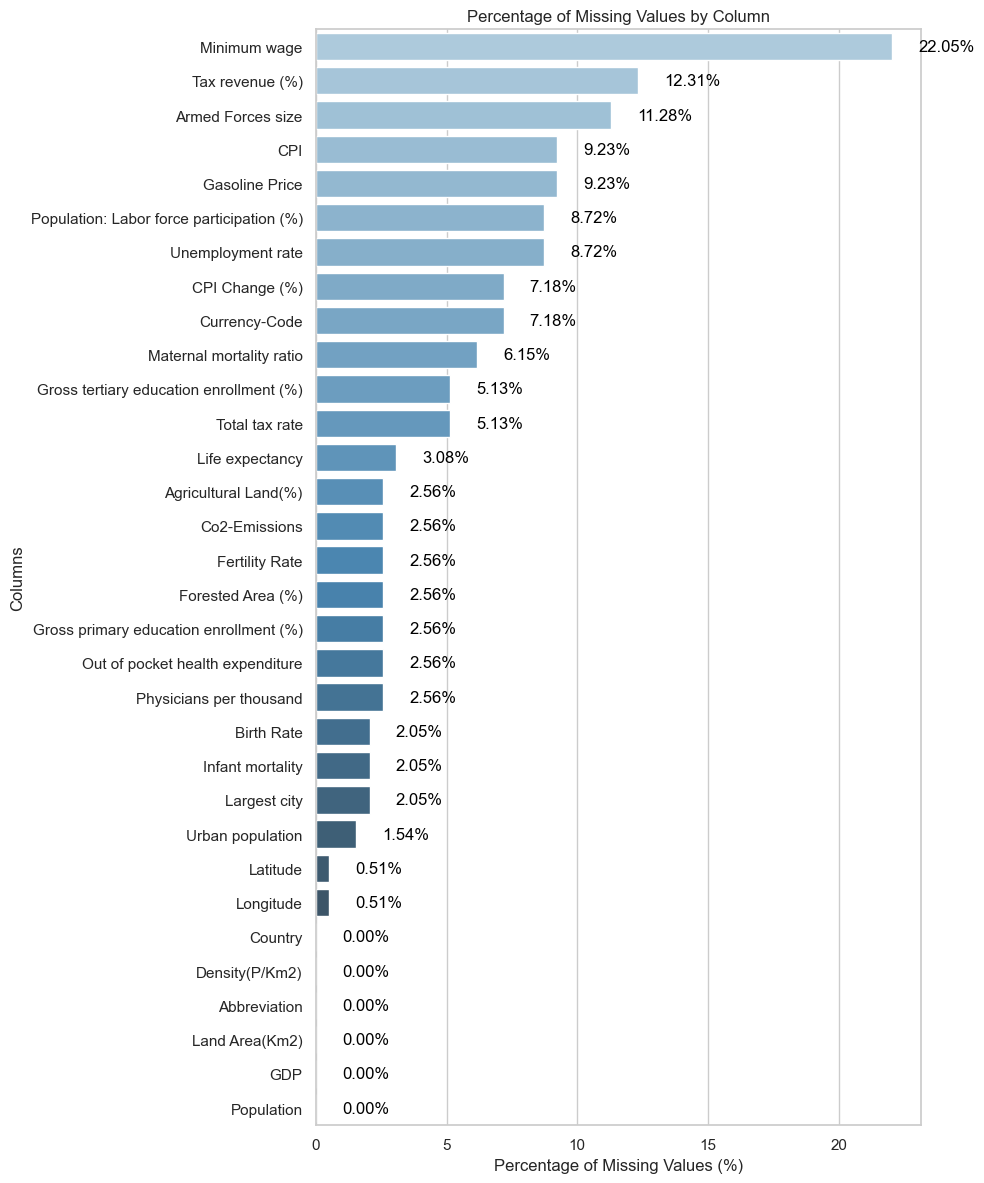

In [13]:
missing_data_summary = (
    cleaned_df.select(
        [
            ((pl.col(column).is_null().sum() / 195) * 100).alias(column)
            for column in cleaned_df.columns
        ]
    )
    .transpose(include_header=True)
    .sort(by="column_0", descending=True)
)

columns = missing_data_summary["column"].to_list()
missing_percentages = missing_data_summary["column_0"].to_list()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 12))
ax = sns.barplot(x=missing_percentages, y=columns, palette="Blues_d", hue=columns)

for p in ax.patches:
    ax.text(
        p.get_width() + 1,
        p.get_y() + p.get_height() / 2,
        f"{p.get_width():.2f}%",
        va="center",
        ha="left",
        color="black",
    )

plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Columns")
plt.title("Percentage of Missing Values by Column")
plt.tight_layout()
plt.show()

As we can see, there are some columns with a considerable amount of missing values. We will try to find information to fill these missing values as far as possible.

We're going to update Forested Area (%) by using the information of forest_area_analysis.ipynb:

In [14]:
ls_countries = [
    "Eswatini",
    "North Macedonia",
    "South Sudan",
    "Monaco",
    "Nauru",
]
ls_values = [29.1, 39.7, 11.3, 0.0, 0.0]

for i in range(0, len(ls_countries)):
    cleaned_df = cleaned_df.with_columns(
        pl.when(pl.col("Country") == ls_countries[i])
        .then(ls_values[i])
        .otherwise(pl.col("Forested Area (%)"))
        .alias("Forested Area (%)")
    )

cleaned_df.filter(pl.col("Country").is_in(ls_countries)).select(
    ["Country", "Forested Area (%)"]
)

Country,Forested Area (%)
str,f64
"""Eswatini""",29.1
"""Monaco""",0.0
"""Nauru""",0.0
"""North Macedonia""",39.7
"""South Sudan""",11.3


Now, we're going to update Life expectancy column by using Kaggle's Global Life Expectancy dataset: (https://www.kaggle.com/datasets/nafayunnoor/global-life-expectancy-data-1950-2023?select=Preprocessed_Life_Expectancy.csv)

In [15]:
null_values = cleaned_df.filter(
    cleaned_df["Life expectancy"].is_null() | cleaned_df["Life expectancy"].is_nan()
)

null_values.select(["Country", "Life expectancy"])

Country,Life expectancy
str,f64
"""Andorra""",null
"""Eswatini""",null
"""Monaco""",null
"""Nauru""",null
"""North Macedonia""",null
"""Tuvalu""",null


In [16]:
ls_countries = ["Andorra", "Eswatini", "Monaco", "Nauru", "North Macedonia", "Tuvalu"]
ls_values = [84.04, 64.12, 86.37, 63.10, 77.39, 67.10]

for i in range(0, len(ls_countries)):
    cleaned_df = cleaned_df.with_columns(
        pl.when(pl.col("Country") == ls_countries[i])
        .then(ls_values[i])
        .otherwise(pl.col("Life expectancy"))
        .alias("Life expectancy")
    )

Filter countries where latitude or longitude is null or empty

In [17]:
null_values = cleaned_df.filter(
    cleaned_df["Latitude"].is_null()
    | cleaned_df["Latitude"].is_nan()
    | cleaned_df["Longitude"].is_null()
    | cleaned_df["Longitude"].is_nan()
)

null_values.select(["Country", "Latitude", "Longitude"])

Country,Latitude,Longitude
str,f64,f64
"""Sao Tome and Principe""",null,null


To update this column, we're going to check the values using the following website: https://www.latlong.net/place/s-o-tom-and-pr-ncipe-island-25177.html

In [18]:
cleaned_df = cleaned_df.with_columns(
    pl.when(pl.col("Country") == "Sao Tome and Principe")
    .then(0.255436)
    .otherwise(pl.col("Latitude"))
    .alias("Latitude")
)

cleaned_df = cleaned_df.with_columns(
    pl.when(pl.col("Country") == "Sao Tome and Principe")
    .then(6.602781)
    .otherwise(pl.col("Longitude"))
    .alias("Longitude")
)

Let's fill Co2-Emissions column:

In [19]:
null_values = cleaned_df.filter(
    cleaned_df["Co2-Emissions"].is_null() | cleaned_df["Co2-Emissions"].is_nan()
)

null_values.select(["Country", "Co2-Emissions"])

Country,Co2-Emissions
str,i64
"""Eswatini""",null
"""Monaco""",null
"""Nauru""",null
"""North Macedonia""",null
"""San Marino""",null


Now, we are going to display the number of missing values in each column again.

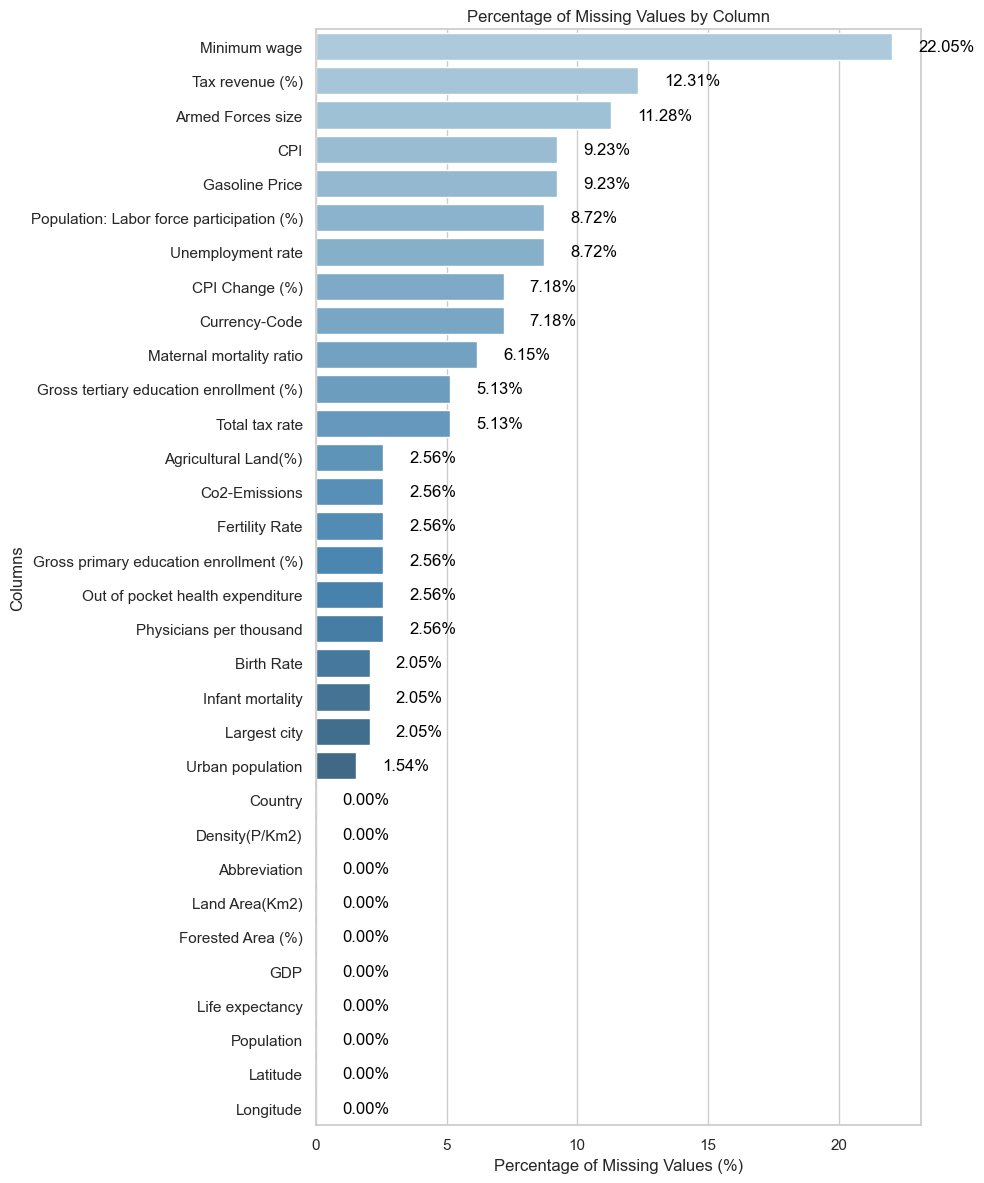

In [20]:
missing_data_summary = (
    cleaned_df.select(
        [
            ((pl.col(column).is_null().sum() / 195) * 100).alias(column)
            for column in cleaned_df.columns
        ]
    )
    .transpose(include_header=True)
    .sort(by="column_0", descending=True)
)

columns = missing_data_summary["column"].to_list()
missing_percentages = missing_data_summary["column_0"].to_list()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 12))
ax = sns.barplot(x=missing_percentages, y=columns, palette="Blues_d", hue=columns)

for p in ax.patches:
    ax.text(
        p.get_width() + 1,
        p.get_y() + p.get_height() / 2,
        f"{p.get_width():.2f}%",
        va="center",
        ha="left",
        color="black",
    )

plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Columns")
plt.title("Percentage of Missing Values by Column")
plt.tight_layout()
plt.show()

Finally, we are going to save the processed dataset in a new file, in order to use it in the next notebooks.

In [21]:
cleaned_df.write_csv("../data/cleaned/data.csv")